**Team Members**


1.   Adil Faruq Habibi
2.   Farensa Fernanda Setiawan
3.   Paramita Citra Indah Mulia

---

# Import libraries required

In [4]:
import os, time
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Data Preparation

## 1.a Extract

## 1.b Transform

## 1.c Load

# 2. Build Model Architecture

## 2.a Create Model

In [ ]:
# CNN Embedding Layer
def create_embedding():
    cnn = Sequential([
        # Input and feature maps
        Conv2D(64, (10,10), activation='relu', input_shape=(105,105,3), name='Conv1'),
        MaxPooling2D(64, (2,2), padding='same', name='Pool1'),
        Conv2D(128, (7,7), activation='relu', name='Conv2'),
        MaxPooling2D(64, (2,2), padding='same', name='Pool2'),
        Conv2D(128, (4,4), activation='relu', name='Conv3'),
        MaxPooling2D(64, (2,2), padding='same', name='Pool3'),
        Conv2D(256, (4,4), activation='relu', name='Conv4'),
        
        # Feature vector
        Flatten(name='FCN'),
        Dense(4096, activation='sigmoid', name='Dense')
    ])
    cnn._name= 'Embedding'
    return cnn

In [ ]:
# L1 Distance Layer
class L1_siamese_dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # Similarity calculation    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [ ]:
# Create siamese model with functional API
def create_siamese_model():
    # Anchor image input
    input_img = Input(shape=(105,105,3), name='Input_img')
    
    # Validation image
    validation_img = Input(shape=(105,105,3), name='Validaiton_img')
    
    # Siamese distance
    embedding = create_embedding()
    siamese_dist = L1_siamese_dist()
    siamese_dist._name = 'Distance'
    distances = siamese_dist(embedding(input_img), embedding(validation_img))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid', name='Output')(distances)
    
    return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNeuralNetwork')

## 2.b Model Instantiation

In [ ]:
# Instantiate embedding CNN and siamese model
embedding = create_embedding()
model = create_siamese_model()

## 2.c Model Summary

In [ ]:
# For embedding CNN
embedding.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 96, 96, 64)        19264     
                                                                 
 Pool1 (MaxPooling2D)        (None, 48, 48, 64)        0         
                                                                 
 Conv2 (Conv2D)              (None, 42, 42, 128)       401536    
                                                                 
 Pool2 (MaxPooling2D)        (None, 21, 21, 128)       0         
                                                                 
 Conv3 (Conv2D)              (None, 18, 18, 128)       262272    
                                                                 
 Pool3 (MaxPooling2D)        (None, 9, 9, 128)         0         
                                                                 
 Conv4 (Conv2D)              (None, 6, 6, 256)         52

In [ ]:
# For siamese model
model.summary()

Model: "SiameseNeuralNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 Validaiton_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Sequential)         (None, 4096)         38960448    ['Input_img[0][0]',              
                                                                  'Validaiton_i

## 2.d Visualize Model Architecture

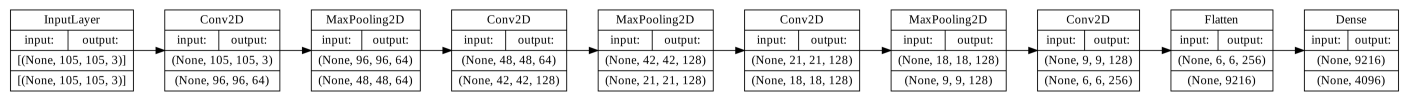

In [ ]:
# Plot embedding
plt.figure(figsize=(25,10))
plot_model(embedding, to_file='embedding.png', 
           show_shapes=True, rankdir='LR', 
           show_layer_names=False,
           dpi=1000)
img = plt.imread('embedding.png')
plt.imshow(img)
plt.axis('off')
plt.show()

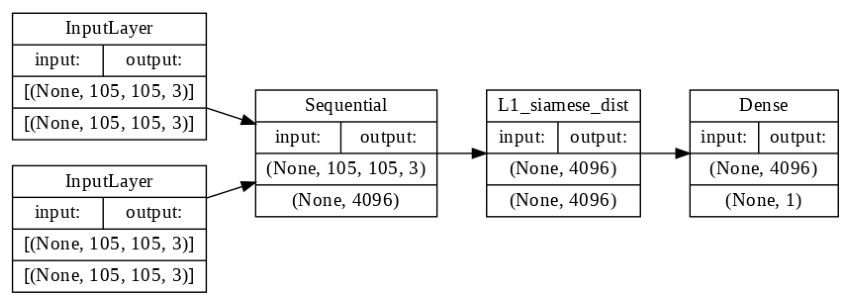

In [ ]:
# Plot siamese model
plt.figure(figsize=(15,8))
plot_model(model, to_file='model.png',
           show_shapes=True, rankdir='LR',
           show_layer_names=False,
           dpi=100)
img = plt.imread('model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# 3. Training Model

## 3.a Custom Training Loop with tf.function Decorators

In [3]:
# set optimizer, loss function and metrics
optimizer = tf.keras.optimizers.Adam(1e-4)
binary_loss = tf.losses.BinaryCrossentropy()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

In [ ]:
# Training checkpoints
!mkdir training_checkpoints
checkpoint_directory = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [ ]:
# Train step function with tf function to ran TensorFlow eagerly
@tf.function
def train_step(batch):
  with tf.GradientTape() as tape:
    # Anchor and pos/neg images
    X = batch[:-1]
    # Label
    y = batch[-1]

    # Forward prop
    ypred = model(X, training=True)
    # Calculate the loss
    loss = binary_loss(y, ypred)
  
  # Calculate the gradients
  grad = tape.gradient(loss, model.trainable_variables)
  # Calculate updated weights and apply to model
  optimizer.apply_gradients(zip(grad, model.trainable_variables))
  train_acc_metric.update_state(y, ypred)

  return loss

In [ ]:
# do the same w the evaluation step
@tf.function
def test_step(batch):
  # Anchor and pos/neg images
  X = batch[:-1]
  # Label
  y = batch[-1]
  
  # Make prediction
  ypred = model(X, training=False)
  val_acc_metric.update_state(y, ypred)

In [ ]:
# Train loop function
def train_model(train_data, val_data, epochs):
  # Loop epoch
  for epoch in range(1, epochs+1):
    print(f'\nEpoch {epoch}/{epochs}')

    start_time = time.time()

    # Loop batch
    for step, train_batch in enumerate(train_data):
      # Run train step
      loss = train_step(train_batch)
      # Log every 7 batches.
      if step % 7 == 0:
        print(
            "Training loss (for one batch) at step %d: %.4f"
            % (step, float(loss))
        )
        print("Seen so far: %d samples" % ((step + 1) * 16))
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for val_batch in val_data:
      test_step(val_batch)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))

    print("Time taken: %.2fs" % (time.time() - start_time))
    
    # Checkpoints
    if epoch % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

# 4. Model Evaluation

# 5. Prepare for Deployment